# Demo for Top-down Neural Attention

This is an example to show how to use Excitation Backprop to visualize CNN classifier's top-down attention.

In [1]:
from prelude import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import transform, filter
import sys, pylab, operator, csv
import util
import os
import urllib
import caffe
import cnn_utils
from cnn_utils import ExcitationBackprop

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

We first load the model files and set the top layers' name. Let's look at the [VGG](http://www.robots.ox.ac.uk/~vgg/) groups 16 layer CNN for object classification trained on ImageNet: https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md

In [3]:
model_root_path = "/home/will/nets/vgg-16/"
model_name = "VGG_ILSVRC_16_layers"
deploy_prototxt_path = os.path.join(model_root_path, "deploy.prototxt")
caffemodel_path = os.path.join(model_root_path, model_name + ".caffemodel")

caffe.set_mode_gpu()
net = caffe.Net(deploy_prototxt_path,
                caffemodel_path,
                caffe.TEST)
with open(os.path.join(config.CAFFE_ROOT, "data/ilsvrc12/synset_words.txt"), "r") as f:
    tag_entries = list(f.readlines())
    [tag_entry.strip().split(" ", 1)[0:2] for tag_entry in tag_entries][0]
 
tags, tag2ID = util.loadTags(os.path.join(config.CAFFE_ROOT, 'data/ilsvrc12/synsets.txt'))
param = dict()


imgScale = 224
topLayerName = 'fc8'
topBlobName = net.top_names[topLayerName][0]
secondTopLayerName = 'fc7'
secondTopBlobName = net.top_names[secondTopLayerName][0]
outputLayerName = 'pool3'
outputBlobName = net.top_names[outputLayerName][0]

We load an image. 
The image is resized to 224 for the shortest dimension.
Since the provided CNN model is converted to a fully convolutional model, we can input images of arbitrary aspect ratio.

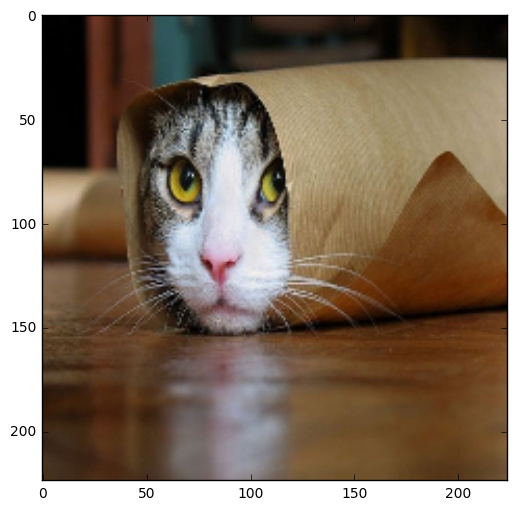

In [4]:
imgName = '../media/images/cat.jpg'
img = caffe.io.load_image(imgName)

new_size = (224, 224)    # The size of VGG16 input images
imgS = transform.resize(img, new_size)


pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)

We do a forward pass and show the top predictions.

In [5]:
transformer = cnn_utils.imagenet_transformer(net)

net.blobs['data'].reshape(1, 3, new_size[0], new_size[1])
net.blobs['data'].data[...] = transformer.preprocess('data', imgS)

eb = ExcitationBackprop(net, 'fc8', 'fc7', 'pool4')

out = net.forward(end = topLayerName)

scores = net.blobs[eb.top_blob_name].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key=operator.itemgetter(1), reverse=True)
print(tagScore[:10])

[('n02124075', 0.2507399), ('n02971356', 0.19677122), ('n02123045', 0.091215588), ('n02123159', 0.051805142), ('n03887697', 0.039891172), ('n03942813', 0.035582565), ('n03584254', 0.015593246), ('n03793489', 0.015230423), ('n03958227', 0.013313737), ('n15075141', 0.011442077)]


Now we try to visualize several object categories present in this image using our contrastive attention formulation.  

In [6]:
classes = [tagScorePair[0] for tagScorePair in tagScore[:3]]
print("Selected classes: "+ str(classes))

Selected classes: ['n02124075', 'n02971356', 'n02123045']


/home/will/thesis/lib/util.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  current_subplot_axes = ax[(i+1)/2, (i+1)%2]
/home/will/thesis/lib/util.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  current_subplot_axes = ax[(i+1)/2, (i+1)%2]
/home/will/thesis/lib/util.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  current_subplot_axes = ax[(i+1)/2, (i+1)%2]


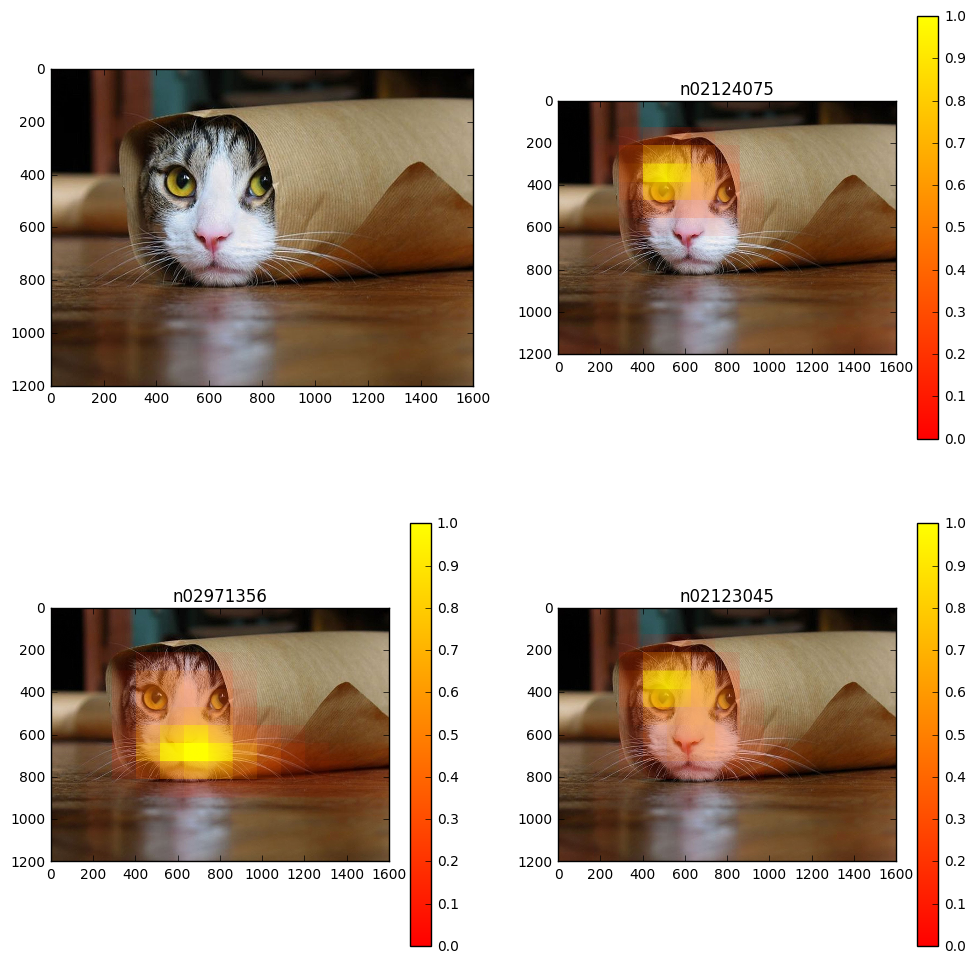

In [7]:
attMaps = []

for i in range(len(classes)):
    tagID = tag2ID[classes[i]]
    attMap = eb.backprop(tagID)
    attMaps.append(attMap)

util.showAttMap(img, attMaps, classes, overlap = True, blur = False)
